# Data acquisition with help of threads

In this notebook, we will explore how threading can be used with measurement context manager or dond functions for faster data acquisition. It is important to note that, QCoDeS provided threading happens per instrument. Meaning, per instrument one thread is created and all parameters from same instrument gets assigned to the same thread for data acquizition. 

Let us begin with some necessary imports.

In [1]:
%matplotlib inline

import numpy as np

import time

import qcodes as qc
from qcodes import Station, load_or_create_experiment, initialise_database, Measurement
from qcodes.tests.instrument_mocks import DummyInstrument, DummyInstrumentWithMeasurement
from qcodes.dataset.plotting import plot_dataset
from qcodes.utils.threading import call_params_threaded
from qcodes.utils.dataset.doNd import do1d

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\v-singak\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\v-singak\.qcodes\logs\210624-17952-qcodes.log


Now, setup some instruments!

In [2]:
dac = DummyInstrument('dac', gates=['ch1', 'ch2'])
dmm1 = DummyInstrumentWithMeasurement(name='dmm1', setter_instr=dac)
dmm2 = DummyInstrumentWithMeasurement(name='dmm2', setter_instr=dac)

Initialize the database and load or create an experiment.

In [3]:
initialise_database()
exp = load_or_create_experiment(
    experiment_name='data_acquisition_with_and_without_threads',
    sample_name="no sample"
)

## Measurement 1: Non threaded data acquisition

In the following measurment, we do not use threads and note down the time taken for the data acquisition. 

In [4]:
meas1 = Measurement(exp=exp, name='exponential_decay_non_threaded_data_acquisition')
meas1.register_parameter(dac.ch1)
meas1.register_parameter(dmm1.v1, setpoints=(dac.ch1,))

In [5]:
t0 = time.perf_counter()
data_acq_time = 0
with meas1.run() as datasaver:             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        
        t1 = time.perf_counter()
        datasaver.add_result((dac.ch1, dac.ch1.get()), (dmm1.v1, dmm1.v1.get()))
        t2 = time.perf_counter()
        
        data_acq_time += t2 - t1
    
    dataset1D1 = datasaver.dataset
    
print('Report:')
print(f'Data acquisition time:            {data_acq_time} s')

Starting experimental run with id: 97. 
Report:
Data acquisition time:            20.147305299999996 s


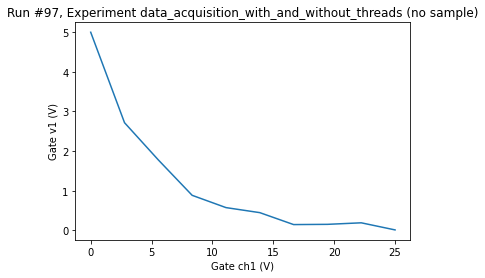

In [6]:
ax, cbax = plot_dataset(dataset1D1)

## Measurement 2: Threaded data acquisition

In this measurement, we use `call_params_threaded` for threaded data acquisition. Here also we record the time taken for data acquisition.

In [7]:
meas2 = Measurement(exp=exp, name='exponential_decay_threaded_data_acquisition')
meas2.register_parameter(dac.ch1)
meas2.register_parameter(dmm1.v1, setpoints=(dac.ch1,))

In [8]:
t0 = time.perf_counter()
data_acq_time = 0
with meas2.run() as datasaver:             
    for set_v in np.linspace(0, 25, 10):
        dac.ch1.set(set_v)
        
        t1 = time.perf_counter()
        datasaver.add_result(*call_params_threaded((dac.ch1, dmm1.v1))) # <----- This line is different
        t2 = time.perf_counter()
        
        data_acq_time += t2 - t1
            
    dataset1D2 = datasaver.dataset
    
print('Report:')
print(f'Data acquisition time:            {data_acq_time} s')

Starting experimental run with id: 98. 
Report:
Data acquisition time:            10.197457100000008 s


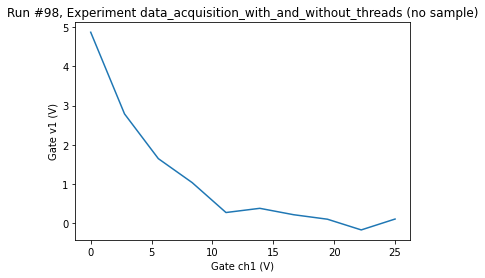

In [9]:
ax, cbax = plot_dataset(dataset1D2)

## Non threaded and threaded data acquisition with do1d

Lets not see how to do non threaded and threaded data acquisition with `do1d` function. Same argument is available on `do0d`, `do2d` and `dond` functions.

### Measurement 3: Non threaded data acquisition with do1d

Starting experimental run with id: 99. 
Report:
Data acquisition time:            21.1311409 s


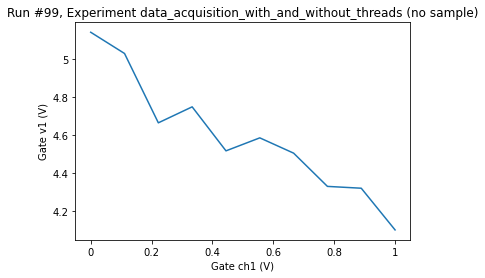

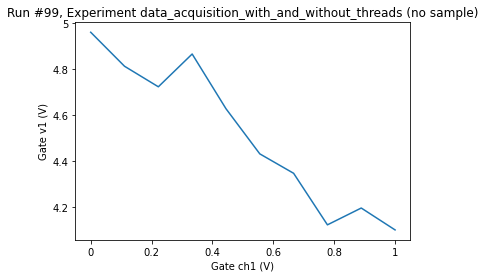

In [10]:
t0 = time.perf_counter()
do1d(dac.ch1, 0, 1, 10, 0, dmm1.v1, dmm2.v1, do_plot=True)
t1 = time.perf_counter()

print('Report:')
print(f'Data acquisition time:            {t1 - t0} s')

###  Measurement 4: Threaded data acquisition with do1d

Starting experimental run with id: 101. 
Report:
Data acquisition time:            11.105231400000008 s


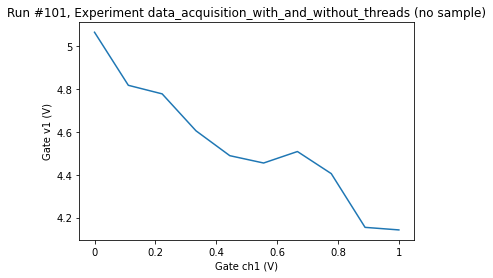

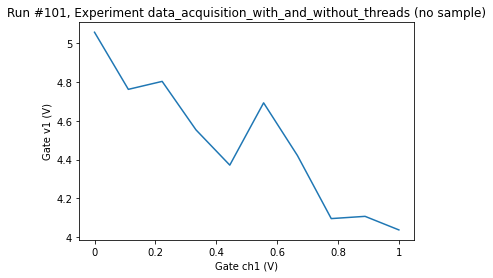

In [12]:
t0 = time.perf_counter()
do1d(dac.ch1, 0, 1, 10, 0, dmm1.v1, dmm2.v1, do_plot=True, use_threads=True) # <------- This line is different
t1 = time.perf_counter()

print('Report:')
print(f'Data acquisition time:            {t1 - t0} s')